In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial.distance import cdist
from scipy.stats import mode
from sklearn.model_selection import train_test_split

### 1.a Download data from Kaggle

In [2]:
df = pd.read_csv('train.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 1.b Display an image of each digit

In [3]:
def display_num(array, position=None):
    img_2d = array.reshape(28,28)
    if position:
        return sns.heatmap(img_2d, cmap = 'Purples', cbar=False, xticklabels=False, yticklabels=False, ax=position)
    else:
        return sns.heatmap(img_2d, cmap = 'Purples', cbar=False, xticklabels=False, yticklabels=False)

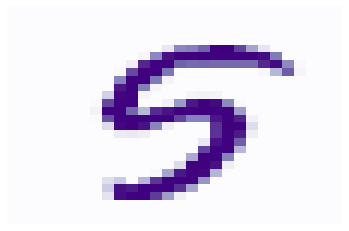

In [4]:
array = np.array(df[df.label==5].iloc[0,1:])

display_num(array)
plt.show()

[]

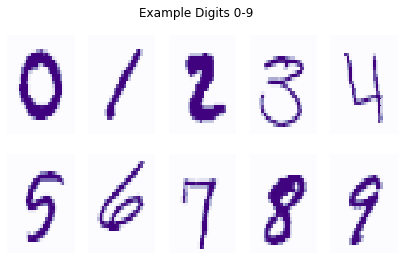

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(7, 4))
fig.suptitle('Example Digits 0-9')

for i in range(10):
    array = np.array(df[df.label==i].iloc[0,1:])
    display_num(array, axes[i//5,i-5])
    
plt.plot()

### 1.c Plot a normalized histogram of digit counts 

In [6]:
value_frequencies = df.label.value_counts(normalize=True).sort_index()
print(value_frequencies)

0    0.098381
1    0.111524
2    0.099452
3    0.103595
4    0.096952
5    0.090357
6    0.098500
7    0.104786
8    0.096738
9    0.099714
Name: label, dtype: float64


The classes in the training data are not completely uniform, but each class has roughly 10% ($1/n_{classes}$) of prior probability.

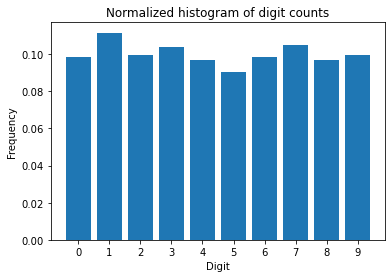

In [7]:
plt.bar(value_frequencies.index,value_frequencies.values)
plt.title("Normalized histogram of digit counts")
plt.xlabel("Digit")
plt.xticks(range(10))
plt.ylabel("Frequency")
plt.show()

### 1.d Compute and show nearest neighbor

In [8]:
def oneNN(sample_x, df):
    """Computes the distance between sample and each row of df.
    Returns sample and best match."""    

    distances = pd.DataFrame()
    distances['dist'] = np.sqrt(np.sum((sample_x - np.array(df.iloc[:,1:]))**2,axis=1))

    best = df.loc[distances[distances['dist']!=0]['dist'].idxmin()]
    min_dist = distances[distances['dist']!=0]['dist'].min()
    
    return best, min_dist

[]

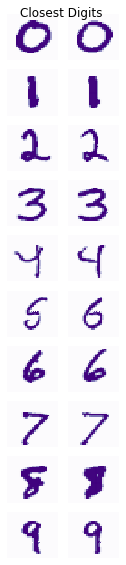

In [17]:
fig, axes = plt.subplots(10, 2, figsize=(2, 10))

for i in range(10):
    sample = df[df.label==i].sample()
    sample_x = np.array(sample)[0][1:]
    best, min_dist = oneNN(sample_x, df)
    
    display_num(sample_x, axes[i,0])
    display_num(np.array(best)[1:], axes[i,1])
    
fig.suptitle('Closest Digits\n', y=0.89)
plt.plot()

### 1.e Plot histogram of genuine and impostor distances

In [10]:
binary_df = pd.read_csv('train.csv')
binary_df = binary_df[(binary_df['label'] == 0) | (binary_df['label'] == 1)]

In [11]:
# We create a matrix of distances between each pair of observations.
dist_matrix = cdist(binary_df.iloc[:,1:],binary_df.iloc[:,1:])

In [12]:
# We create a matrix that shows, for each pair of observations, True for genuine matches and False for impostor matches.
v = np.array(binary_df["label"]).reshape(1,-1)
is_genuine = np.transpose(v)==v

In [13]:
# As the matrices are symmetric, we only need the values in the upper triangle of the 2 matrices (is_genuine and dist_matrix).
is_genuine_1D = is_genuine[np.triu_indices(is_genuine.shape[1], 1)].reshape(-1,1)
distances_1D = dist_matrix[np.triu_indices(dist_matrix.shape[1], 1)].reshape(-1,1)

final = np.hstack((is_genuine_1D, distances_1D))
print(final)

[[0.00000000e+00 3.30763873e+03]
 [1.00000000e+00 2.21755225e+03]
 [0.00000000e+00 3.50871087e+03]
 ...
 [0.00000000e+00 2.94424557e+03]
 [1.00000000e+00 1.27990273e+03]
 [0.00000000e+00 2.81221994e+03]]


In [14]:
final_df = pd.DataFrame(final, columns=["is_genuine","dist"])
genuine_df = final_df[final_df["is_genuine"]==1]
impostor_df = final_df[final_df["is_genuine"]==0]
print("There are %s impostors and %s genuines." % (impostor_df.shape[0], genuine_df.shape[0]))

There are 19354288 impostors and 19502232 genuines.


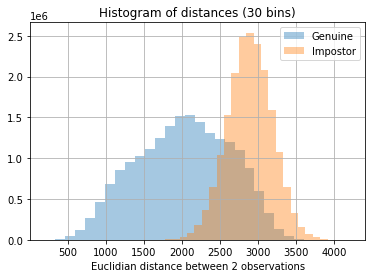

In [15]:
genuine_df.dist.hist(alpha=0.4, bins=30, label="Genuine")
impostor_df.dist.hist(alpha=0.4, bins = 30, label="Impostor")
plt.legend()
plt.title("Histogram of distances (30 bins)")
plt.xlabel("Euclidian distance between 2 observations")
plt.show()

### 1.f Generate an ROC curve

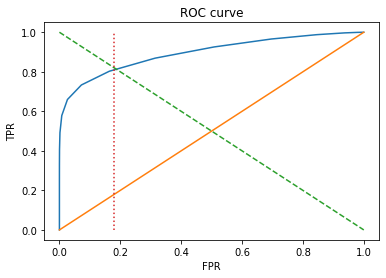

In [23]:
# We need to compute the TPR and FPR at different thresholds.
def roc(df, n_thr=30):
    
    df_genuines = df[df['is_genuine'] == 1]
    df_impostors = df[df['is_genuine'] == 0]
    
    thresholds = np.linspace(0,df.dist.max(),n_thr)
    
    fpr, tpr = [], []
    for i in thresholds:
        tpr.append(df_genuines[df_genuines['dist'] <= i].shape[0] / df_genuines.shape[0])
        fpr.append(df_impostors[df_impostors['dist'] <= i].shape[0] / df_impostors.shape[0])
    
    return fpr, tpr

fpr, tpr = roc(final_df)
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
plt.plot([0,1],[1,0], '--')
plt.plot([0.18,0.18],[0,1], ':')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

## Alternative 1.e & 1.f

### 1.e Plot histogram of genuine and impostor distances

In [24]:
# We create a matrix that shows, for each pair of observations:
map_class = {1:"TP",
       2:"FP",
       -2:"TN",
       -1:"FN"}

v = np.array(binary_df["label"]).reshape(1,-1)
v1 = np.where(v == 0, 2, 1)
v2 = np.where(v == 0, -1, 1)
classification = np.multiply(np.transpose(v1),v2)
print(classification)
print(classification.shape)

[[ 1 -1  1 ...  1 -1  1]
 [ 2 -2  2 ...  2 -2  2]
 [ 1 -1  1 ...  1 -1  1]
 ...
 [ 1 -1  1 ...  1 -1  1]
 [ 2 -2  2 ...  2 -2  2]
 [ 1 -1  1 ...  1 -1  1]]
(8816, 8816)


In [25]:
# We delete the diagonal in both matrices
np.fill_diagonal(classification, 0)
classification_1D = classification[classification != 0].reshape(-1,1)
dist_1D = dist_matrix[dist_matrix != 0].reshape(-1,1)

final = np.hstack((classification_1D, dist_1D))
print(final)
print(final.shape)

[[-1.00000000e+00  3.30763873e+03]
 [ 1.00000000e+00  2.21755225e+03]
 [-1.00000000e+00  3.50871087e+03]
 ...
 [-1.00000000e+00  3.05098623e+03]
 [ 1.00000000e+00  1.27990273e+03]
 [-1.00000000e+00  2.81221994e+03]]
(77713040, 2)


In [26]:
final_df = pd.DataFrame(final, columns=["class","dist"])
final_df["class"] = final_df["class"].map(map_class)
final_df["class"].value_counts()

TP    21935172
FN    19354288
FP    19354288
TN    17069292
Name: class, dtype: int64

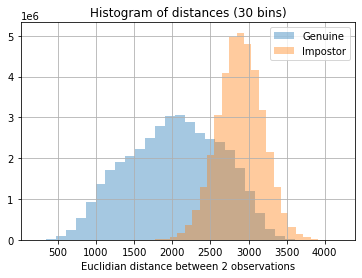

In [27]:
final_df[(final_df["class"] == "TP") | (final_df["class"] == "TN")].dist.hist(alpha=0.4, bins=30, label='Genuine')
final_df[(final_df["class"] == "FP") | (final_df["class"] == "FN")].dist.hist(alpha=0.4, bins=30, label='Impostor')
plt.legend()
plt.title("Histogram of distances (30 bins)")
plt.xlabel("Euclidian distance between 2 observations")
plt.show()

### 1.f Generate an ROC curve

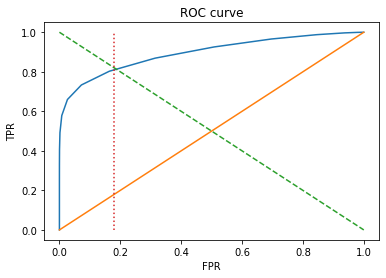

In [28]:
# We need to compute the TPR and FPR at different thresholds.
def roc(df, n_thr=30):
    
    thresholds = np.linspace(0,df.dist.max(),n_thr)
    
    df_genuines = df[(df['class'] == "TP") | (df['class'] == "TN")]
    df_impostors = df[(df['class'] == "FP") | (df['class'] == "FN")]
    
    fpr, tpr = [], []
    for i in thresholds:
        tpr.append(df_genuines[(df_genuines['dist'] <= i)].shape[0] / df_genuines.shape[0])
        fpr.append(df_impostors[(df_impostors['dist'] <= i)].shape[0] / df_impostors.shape[0])
    
    return fpr, tpr

fpr, tpr = roc(final_df)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])
plt.plot([0,1],[1,0], '--')
plt.plot([0.18,0.18],[0,1], ':')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

## Back to the rest of the exercise
### 1.g Implement a KNN classifier

In [287]:
class kNN:
        
    def __init__(self, k):
        self.k = k
        print("Created %sNN classifier" % k)
        
    def fit(self, X_train, y_train):
        self.X_train, self.y_train = X_train, y_train
        print('"Trained" on %s observations, with %s features.' % X_train.shape)
        
    def predict(self, X_test):
        dist_matrix = cdist(X_test, self.X_train)
        best_idx = np.argsort(dist_matrix, axis=1)[:,:self.k]

        best_labels = np.array(y_train.iloc[best_idx.reshape(1,-1)[0]]).reshape(-1,self.k)
        
        most_frequent = mode(best_labels, axis=1)
        self.y_pred = most_frequent.mode
        self.y_prob = most_frequent.count / self.k
        
        return self.y_pred
    

### 1.h Train on half of training data, test on other half

In [288]:
# Splitting training data into two halves: train and test.
df_train, df_test = train_test_split(df, test_size=0.5)
X_train, y_train = df_train.iloc[:,1:], df_train.iloc[:,0]

# We sample 5000 rows of test to reduce computation time
df_test_sampled = df_test.sample(5000)
X_test, y_test = df_test_sampled.iloc[:,1:], df_test_sampled.iloc[:,0]

In [289]:
model = kNN(3)
model.fit(X_train, y_train)

Created 3NN classifier
"Trained" on 21000 observations, with 784 features.


In [290]:
y_pred = model.predict(X_test)

In [291]:
def avg_accur(y_test, y_pred):
    loss = y_test.values != y_pred.reshape(1,-1)[0]
    return 1 - (loss.sum() / loss.shape[0])

In [292]:
print("The average accuracy is %s" % avg_accur(y_test, y_pred))

The average accuracy is 0.9626


### 1.i Generate the Confusion Matrix

In [293]:
def join(y_test, y_pred):
    return pd.DataFrame(np.hstack([y_test.values.reshape(-1,1), y_pred]), columns=["y_test", "y_pred"])

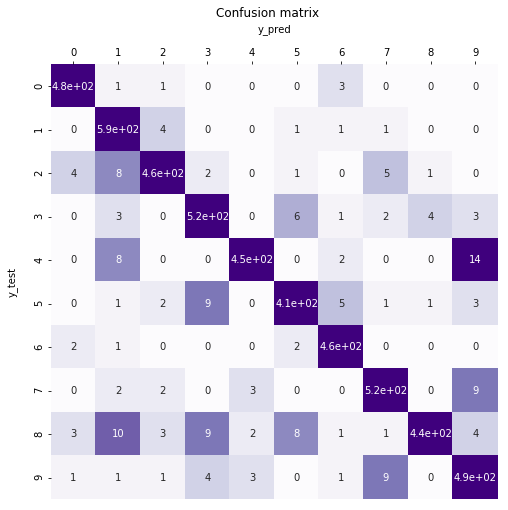

In [251]:
joined = join(y_test, y_pred)
confusion = np.empty((10,10))
for i in range(10):
    for j in range(10):
        confusion[i,j] = joined[(joined["y_test"] == i) & (joined["y_pred"] == j)].shape[0]

confusion_wo_diag = confusion.copy()
np.fill_diagonal(confusion_wo_diag, 0)

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(confusion, axes=ax, annot=True, cbar=False, cmap="Purples", vmax=confusion_wo_diag.max())
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
plt.xlabel("y_pred\n")
plt.ylabel("y_test\n")
plt.suptitle("Confusion matrix",)
plt.show()

The numbers that are misclassified the most frequently are
- the 4s (confused 14 times with 9s and 8 times with 1s)
- the 8s (confused 10 times with 2s, 9 times with 3s, and 8 times with 5s)
- ...

### 1.j Predict y_test and submit on Kaggle

In [3]:
X_train, y_train = df.iloc[:,1:], df.iloc[:,0]
X_test = pd.read_csv('test.csv')
X_test.shape

(28000, 784)

In [4]:
from sklearn.neighbors import KNeighborsClassifier

In [5]:
knn = KNeighborsClassifier(n_neighbors=10, weights="distance", n_jobs=-1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [6]:
y_pred

array([2, 0, 9, ..., 3, 9, 2], dtype=int64)

In [275]:
df1 = pd.DataFrame(list(range(1,len(y_pred)+1)), columns=["ImageId"])
df1["Label"] = y_pred
df1.to_csv("submission.csv", index=False)